## Applying bubble entropy on EEG classification of REM vs NREM sleep:

This notebook demonstrates that Bubble Entropy, originally proposed for HRV analysis, generalizes to EEG sleep signals and can separate REM from NREM sleep using a single scalar feature without parameter tuning

In [7]:
!pip -q install mne scikit-learn numpy pandas matplotlib

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import mne


## Importing the data:

In [8]:
from mne.datasets.sleep_physionet import age

subjects = [0]

paths = age.fetch_data(subjects=subjects, recording=[1], on_missing="warn")

psg_path, hyp_path = paths[0]

print("PSG:", psg_path)
print("HYP:", hyp_path)


Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating /root/mne_data


100%|█████████████████████████████████████| 48.3M/48.3M [00:00<00:00, 30.9GB/s]
100%|█████████████████████████████████████| 4.62k/4.62k [00:00<00:00, 1.99MB/s]

Download complete in 02m07s (46.1 MB)
PSG: /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf
HYP: /root/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf


In [11]:
raw = mne.io.read_raw_edf(psg_path, preload=True)
annot = mne.read_annotations(hyp_path)
raw.set_annotations(annot)

print("Channels:", raw.ch_names)
print("Sampling rate:", raw.info["sfreq"])
print("Sleep stage labels:", sorted(set(annot.description)))


Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...


/tmp/ipython-input-1605531134.py:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
/tmp/ipython-input-1605531134.py:1: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True)
/tmp/ipython-input-1605531134.py:1: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True)


Channels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
Sampling rate: 100.0
Sleep stage labels: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipython-input-1605531134.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot)


In [21]:
preferred = "EEG Fpz-Cz"

## Classify into 2 boxes

In [13]:
event_id = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 5,
    "Sleep stage R": 6,
}

events, _ = mne.events_from_annotations(raw, event_id=event_id, verbose=False)

epochs = mne.Epochs(
    raw,
    events,
    event_id=event_id,
    tmin=0,
    tmax=30,
    baseline=None,
    preload=True,
    verbose=False,
)

X_epochs = epochs.get_data()[:, 0, :]
stages = epochs.events[:, 2]

REM = event_id["Sleep stage R"]
NREM = {event_id["Sleep stage 1"], event_id["Sleep stage 2"],
        event_id["Sleep stage 3"], event_id["Sleep stage 4"]}

mask = [(s == REM) or (s in NREM) for s in stages]

X_epochs = X_epochs[mask]
y = np.array([1 if s == REM else 0 for s in stages[mask]])

print("Epochs:", len(y), "| REM:", y.sum(), "| NREM:", (y==0).sum())


Epochs: 141 | REM: 6 | NREM: 135


## Define Quick Bubble Entropy

In [36]:
from collections import Counter

def _inversion_count(arr):
    """
    Count inversions in O(m log m) using merge-sort.
    Bubble-sort swap count == inversion count.
    """
    a = list(arr)

    def sort_count(x):
        n = len(x)
        if n <= 1:
            return x, 0
        mid = n // 2
        left, invL = sort_count(x[:mid])
        right, invR = sort_count(x[mid:])

        merged = []
        i = j = 0
        inv = invL + invR

        while i < len(left) and j < len(right):
            if left[i] <= right[j]:
                merged.append(left[i])
                i += 1
            else:
                merged.append(right[j])
                j += 1
                inv += (len(left) - i)
        merged.extend(left[i:])
        merged.extend(right[j:])
        return merged, inv

    _, inv = sort_count(a)
    return inv


def _renyi2_entropy_from_counts(counts):
    """
    H2 = -log(sum p_i^2)
    """
    p = np.array(list(counts.values()), dtype=float)
    p /= p.sum()
    return -np.log(np.sum(p**2))

In [38]:
def _initial_inversions(window):
    inv = 0
    m = len(window)
    for i in range(m):
        wi = window[i]
        for j in range(i + 1, m):
            if wi > window[j]:
                inv += 1
    return inv


def _sliding_inversion_counts_tau1(x, m):
    """
    Fast O(N*m) inversion counts for all sliding windows of length m, tau=1.
    """
    x = np.asarray(x)
    N = len(x)
    L = N - m + 1
    if L <= 0:
        return []

    w = x[:m].copy()
    inv = _initial_inversions(w)
    invs = [inv]

    for i in range(1, L):
        out = w[0]
        inv -= int(np.sum(out > w[1:]))

        w[:-1] = w[1:]
        new = x[i + m - 1]
        w[-1] = new

        inv += int(np.sum(w[:-1] > new))
        invs.append(inv)

    return invs
def bubble_entropy(x, m=10, tau=1):
    x = np.asarray(x)
    N = len(x)

    Lm  = N - (m - 1) * tau
    Lm1 = N - m * tau
    if Lm < 2 or Lm1 < 2:
        return np.nan

    if tau == 1:
        swaps_m  = _sliding_inversion_counts_tau1(x, m)
        swaps_m1 = _sliding_inversion_counts_tau1(x, m + 1)

    else:
        swaps_m  = [inversion_count(x[i:i+m*tau:tau])
                    for i in range(Lm)]
        swaps_m1 = [inversion_count(x[i:i+(m+1)*tau:tau])
                    for i in range(Lm1)]

    Hm  = renyi2(Counter(swaps_m))
    Hm1 = renyi2(Counter(swaps_m1))

    return (Hm1 - Hm) / np.log((m + 1) / (m - 1))


## Box plot and stats:

/tmp/ipython-input-687104785.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([bEn[(y==0)&good], bEn[(y==1)&good]],


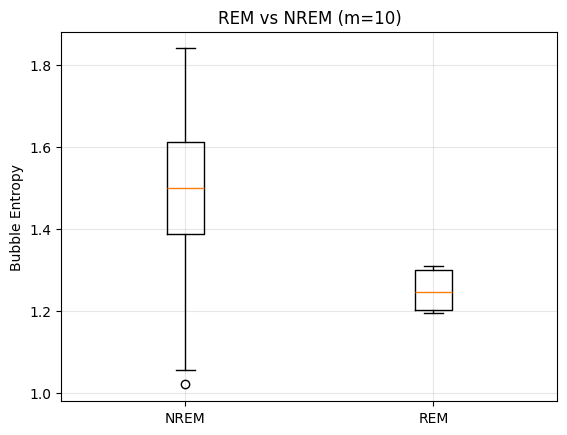

In [39]:
m = 10
bEn = np.array([bubble_entropy(ep, m=m) for ep in X_epochs])
good = np.isfinite(bEn)

plt.boxplot([bEn[(y==0)&good], bEn[(y==1)&good]],
            labels=["NREM", "REM"])
plt.ylabel("Bubble Entropy")
plt.title(f"REM vs NREM (m={m})")
plt.grid(True, alpha=0.3)
plt.show()


In [17]:
from scipy.stats import mannwhitneyu

nrem = bEn[(y==0) & good]
rem  = bEn[(y==1) & good]

U, p = mannwhitneyu(nrem, rem, alternative="two-sided")
print("Mann–Whitney U:", U)
print("p-value:", p)
print("means: NREM =", nrem.mean(), "REM =", rem.mean())
print("medians: NREM =", np.median(nrem), "REM =", np.median(rem))


Mann–Whitney U: 704.0
p-value: 0.0010015114359306246
means: NREM = 1.0238325281254887 REM = 0.8670314015665143
medians: NREM = 1.039582629109622 REM = 0.8636050087564187


In [23]:
from sklearn.metrics import roc_auc_score

scores = bEn[good]
labels = y[good]

auc = roc_auc_score(labels, scores)
print("ROC-AUC using bEn alone:", auc)


ROC-AUC using bEn alone: 0.13086419753086423


In [24]:
from sklearn.metrics import accuracy_score

best_acc, best_t = -1, None
for t in np.unique(scores):
    pred = (scores >= t).astype(int)
    acc = accuracy_score(labels, pred)
    if acc > best_acc:
        best_acc, best_t = acc, t

print("Best threshold (scores >= t => REM):", best_t)
print("Best accuracy (single subject):", best_acc)


Best threshold (scores >= t => REM): 1.2752006682706614
Best accuracy (single subject): 0.950354609929078
